# LSTM 기반의 삼성전자 주가 예측 예제

In [1]:
# https://www.youtube.com/watch?v=LLLVYkXJw30

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU

2021-12-21 14:36:22.235010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 14:36:22.235054: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print(tf.__version__)

2.7.0


# 1. Load

In [4]:
# yahoo finance data
raw_df = pd.read_csv('/home/ubuntu/workspace/005930.KS_3MA_5MA.csv')

raw_df.head()
# Date
# Open : 시가
# Hight : 고가
# Low : 저가
# Close : 종가
# Adj Close : Adjusted Close Price(수정 종가), 배당금 등을 반영, 과거 실적 분석에 주로 사용
# 3MA, 5MA : 이동 평균

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


# 2. 전처리

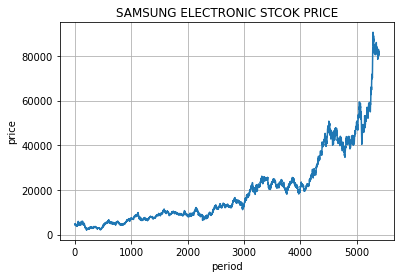

In [5]:
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close')

plt.show()

### (1) 데이터 전처리 (Missing Data 처리, 정규화 등)

In [6]:
# 통계정보 확인

raw_df.describe()
    # Volume = 0 : 결측 처리

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5.389000e+03,5393.000000,5391.000000
mean,22801.887178,23043.991464,22559.285582,22801.909445,19920.044863,2.207838e+07,19934.224878,19925.585966
std,17736.201238,17906.827402,17572.109940,17733.296811,17322.636387,1.564053e+07,17313.297249,17292.697383
min,2540.000000,2760.000000,2420.000000,2730.000000,2117.926025,0.000000e+00,2164.473877,2179.989746
25%,9880.000000,9990.000000,9800.000000,9900.000000,7726.937988,1.185265e+07,7726.939453,7709.871631
50%,15760.000000,15940.000000,15560.000000,15800.000000,12808.596680,1.803935e+07,12802.806970,12809.314840
75%,29280.000000,29560.000000,29000.000000,29280.000000,24566.556640,2.771475e+07,24558.166020,24555.269140
max,90300.000000,96800.000000,89500.000000,91000.000000,90597.414060,1.642150e+08,90033.252600,89562.014060


In [7]:
# Missing Data 확인

raw_df.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          2
5MA          4
dtype: int64

In [8]:
# 통계 정보에서 이미 본거...
# # 최소값이 0 인 column 체크

# for col in raw_df.columns:

#     if raw_df[col].min() == 0:
#         col_name = col
#         print(col_name, type(col_name))

In [9]:
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
23,2000-02-04,5130.0,5130.0,5130.0,5130.0,3979.839355,0.0,4010.871419,4097.760644
41,2000-03-01,5120.0,5120.0,5120.0,5120.0,3972.081543,0.0,3889.329834,3914.672510
66,2000-04-05,6800.0,6800.0,6800.0,6800.0,5275.420410,0.0,5353.000163,5345.242773
72,2000-04-13,6910.0,6910.0,6910.0,6910.0,5360.757324,0.0,5409.891439,5495.746680
84,2000-05-01,6000.0,6000.0,6000.0,6000.0,4654.781250,0.0,4499.622070,4443.765039
...,...,...,...,...,...,...,...,...,...
4623,2018-04-30,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47560.473960,46736.421880
4624,2018-05-02,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47194.763280
4625,2018-05-03,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47663.931250
5077,2020-03-09,56500.0,56500.0,56500.0,56500.0,53774.468750,0.0,54186.897140,53983.855470


In [10]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 116
3MA: 0
5MA: 0


In [11]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인(변경 결과 점검)

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


In [12]:
# missing data 확인 -> NaN값 추가됨 확인

raw_df.isnull().sum()
# raw_df.isnull().any() # any() : 데이터에 하나라도 True이면 True

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [13]:
# NaN 데이터 확인
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [14]:
# missing data Drop

raw_df = raw_df.dropna()
#raw_df.isnull().sum()
raw_df.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
3MA          False
5MA          False
dtype: bool

### (2) 표준화

In [15]:
# 정규화 (Date 제외한 모든 수치부분 정규화)
# Min, Max 표준화

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close','3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5264  0.891750  0.830923  0.896647  0.881047   0.885878  0.895299  0.903144   
5265  0.892890  0.834113  0.897795  0.885578   0.890399  0.894920  0.900854   
5266  0.899727  0.841557  0.903537  0.895774   0.900571  0.897955  0.902457   
5267  0.895169  0.835177  0.898944  0.885578   0.890399  0.899472  0.902228   
5268  0.895169  0.833050  0.896647  0.881047   0.885878  0.897955  0.901083   

        Volume  
0     0.285359  
1     0.363715  


# 3. Train

### (1) Train Data

In [16]:
# feature_df, label_df 생성

feature_cols = [ '3MA', '5MA', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5269, 3) (5269, 1)


In [17]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [18]:
# 시계열 데이터 생성 (make_sequence_dataset)
# 시계열 데이터를 위한 window_size = 40 선정
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)
# X.shape = (5229, 40, 3) = (batch size, time step, input dims)

(5229, 40, 3) (5229, 1)


In [19]:
Y[0]

array([0.02797024])

In [20]:
X[0] # 각각 [ '3MA', '5MA', 'Adj Close' ]

array([[0.0251922 , 0.02569814, 0.02665503],
       [0.02563365, 0.02509431, 0.02665503],
       [0.02616339, 0.02534295, 0.02621662],
       [0.02598681, 0.02550278, 0.02612894],
       [0.02616339, 0.02601781, 0.02718112],
       [0.02728174, 0.02660388, 0.0295485 ],
       [0.02842951, 0.02718994, 0.0295485 ],
       [0.0288121 , 0.02761618, 0.02832097],
       [0.02863553, 0.02820225, 0.02902244],
       [0.02798808, 0.02829105, 0.02761953],
       [0.02722289, 0.02758066, 0.02604126],
       [0.02545707, 0.02640853, 0.02376156],
       [0.02427987, 0.02555607, 0.02411228],
       [0.02375012, 0.02463256, 0.02446299],
       [0.02486847, 0.02452601, 0.02709345],
       [0.02516277, 0.02431289, 0.02498909],
       [0.02457417, 0.02409978, 0.02270939],
       [0.02289665, 0.02369131, 0.02209562],
       [0.0215723 , 0.02299869, 0.02104345],
       [0.02098369, 0.02116944, 0.02200792],
       [0.02186659, 0.0213648 , 0.02367388],
       [0.02360297, 0.0221995 , 0.02621662],
       [0.

In [21]:
# train, test 분리 : 끝 200일을 Test 데이터로

#split = int(len(X)*0.95)
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5029, 40, 3) (5029, 1)
(200, 40, 3) (200, 1)


# 4. Train

### (1) LSTM

In [22]:
# model 생성

model = Sequential()

model.add(LSTM(128 # Node의 수
               , activation='tanh' # 활성 함수
               , input_shape=x_train[0].shape # input shape (40, 3)
              )
         )

# 출력층
model.add(Dense(1
                , activation='linear'
               )
         )

2021-12-21 14:36:24.595377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 14:36:24.595424: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 14:36:24.595445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b9e1efe7664d): /proc/driver/nvidia/version does not exist
2021-12-21 14:36:24.595678: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.compile(loss='mse'
              , optimizer='adam'
              , metrics=['mae']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Parameter 수
# 참고 : https://medium.com/deep-learning-with-keras/lstm-understanding-the-number-of-parameters-c4e087575756
# 참고 : https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889
# num_params = g × [h(h+i) + h]
# g, no. of FFNNs in a unit (RNN has 1, GRU has 3, LSTM has 4)
# h, size of hidden units
# i, dimension/size of input

4 * (128*(128 + 3) + 128)

# 중요 : Time Step은 영향 없음 -> same “W”, “U”, and “b” are shared throughout the time-step

67584

In [24]:
# Early Stop & Training

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
# 'val_loss' : Validation상의 loss
# patience : 성능향상이 없는 epoch 수

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
315/315 [==============================] - 10s 28ms/step - loss: 6.1661e-04 - mae: 0.0102 - val_loss: 0.0013 - val_mae: 0.0259
Epoch 2/100
315/315 [==============================] - 8s 26ms/step - loss: 8.8518e-05 - mae: 0.0061 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 3/100
315/315 [==============================] - 8s 26ms/step - loss: 8.3292e-05 - mae: 0.0060 - val_loss: 0.0024 - val_mae: 0.0430
Epoch 4/100
315/315 [==============================] - 8s 26ms/step - loss: 6.9610e-05 - mae: 0.0055 - val_loss: 0.0010 - val_mae: 0.0252
Epoch 5/100
315/315 [==============================] - 8s 26ms/step - loss: 7.3736e-05 - mae: 0.0056 - val_loss: 5.1389e-04 - val_mae: 0.0156
Epoch 6/100
315/315 [==============================] - 8s 26ms/step - loss: 7.3844e-05 - mae: 0.0057 - val_loss: 4.2599e-04 - val_mae: 0.0160
Epoch 7/100
315/315 [==============================] - 8s 26ms/step - loss: 6.0853e-05 - mae: 0.0051 - val_loss: 5.6342e-04 - val_mae: 0.0175
Epoch 8/100
315/315 [

### (2) LSTM 결과

In [45]:
# Parameter Weight
for weight in model.get_weights(): # weights from Dense layer omitted
    print(weight.shape)

(3, 768)
(256, 768)
(2, 768)
(256, 1)
(1,)


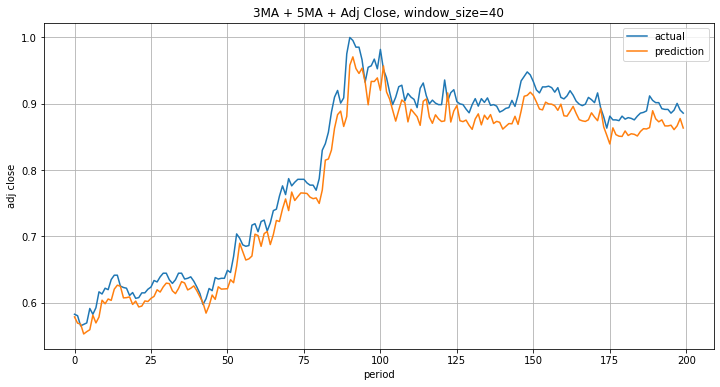

In [25]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [26]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.028634068528279162


### (3) GRU

In [27]:
# model 생성

model = Sequential()

model.add(GRU(256, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               200448    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Parameter 수

# num_params = 2 × g × [h(h+i) + h] (first term is 2 because of bidirectionality) ??????????? 양방향이면 h*2 아닌가?????
# g, no. of FFNNs in a unit (RNN has 1, GRU has 3, LSTM has 4)
# h, size of hidden units
# i, dimension/size of input

3 * (256*(256 + 3) + 256*2)

200448

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
315/315 [==============================] - 13s 39ms/step - loss: 6.9288e-04 - mae: 0.0101 - val_loss: 4.6156e-04 - val_mae: 0.0150
Epoch 2/100
315/315 [==============================] - 12s 37ms/step - loss: 5.3903e-05 - mae: 0.0048 - val_loss: 8.0303e-04 - val_mae: 0.0227
Epoch 3/100
315/315 [==============================] - 12s 38ms/step - loss: 4.8243e-05 - mae: 0.0046 - val_loss: 3.0865e-04 - val_mae: 0.0125
Epoch 4/100
315/315 [==============================] - 12s 38ms/step - loss: 4.6521e-05 - mae: 0.0046 - val_loss: 7.4557e-04 - val_mae: 0.0227
Epoch 5/100
315/315 [==============================] - 12s 38ms/step - loss: 4.2013e-05 - mae: 0.0044 - val_loss: 2.5339e-04 - val_mae: 0.0113
Epoch 6/100
315/315 [==============================] - 12s 38ms/step - loss: 4.4080e-05 - mae: 0.0045 - val_loss: 7.3832e-04 - val_mae: 0.0230
Epoch 7/100
315/315 [==============================] - 12s 37ms/step - loss: 3.6396e-05 - mae: 0.0041 - val_loss: 4.1652e-04 - val_mae: 0.0158

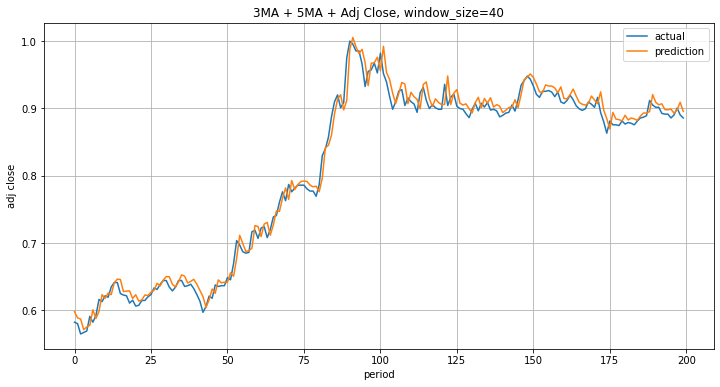

In [30]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [31]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.014103196249915349
